In [9]:
#Allows for installation 
# install.packages(c("pageviews",
#                    "prophet"))


In [10]:
library(pageviews)
library(ggplot2)
library(dplyr)
library(prophet)
options(repr.plot.width=8, repr.plot.height=4)

In [11]:
#Download pageviews data!
pumpkin.views <- article_pageviews(project = "en.wikipedia.org", article = "Pumpkin"
  , start = as.Date('2015-01-01'), end = as.Date("2017-11-01")
  , user_type = c("all-agents"), platform = c("all-access"))

In [12]:
#Keep only columns of interest and rename for prophet
pumpkin.views <- pumpkin.views %>%
    mutate(ds=date, y=log(views)) %>%
    select(ds, y)
head(pumpkin.views)

ds,y
2015-07-01,7.030857
2015-07-02,6.989335
2015-07-03,6.886532
2015-07-04,6.911747
2015-07-05,7.097549
2015-07-06,7.202661


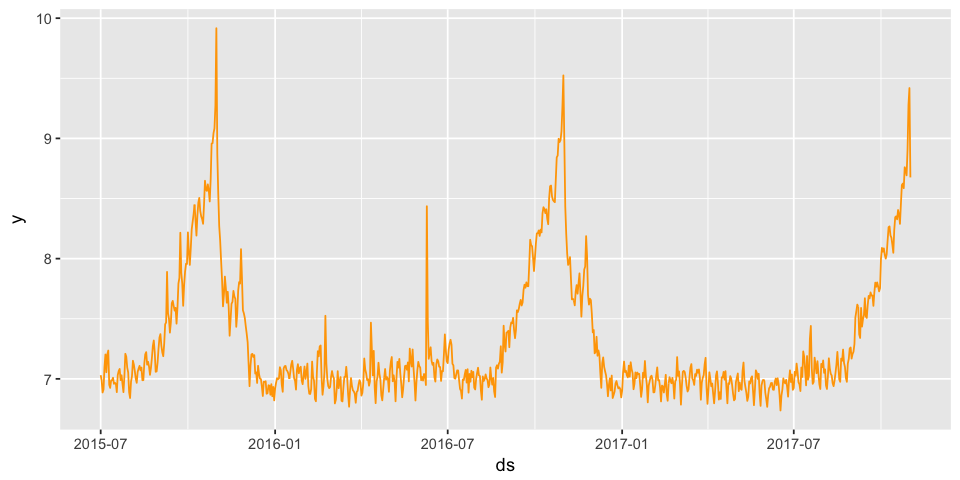

In [13]:
ggplot(pumpkin.views, aes(ds, y)) + geom_line(colour='orange')

# Features of this problem:

1. Strong yearly seasonality.
2. Minimal trend.
3. Thanksgiving holiday matters, but won't be captured by yearly seasonality.
4. Possible outlier in June 2016?


# Run our first model

In [14]:
m <- prophet(pumpkin.views)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -5.53759
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [15]:
#Make dataframe representing the future
future <- make_future_dataframe(m, periods = 400)
tail(future)

,ds
1250,2018-12-01
1251,2018-12-02
1252,2018-12-03
1253,2018-12-04
1254,2018-12-05
1255,2018-12-06


In [16]:
#Make a forecast
forecast <- predict(m, future)
tail(forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')])

,ds,yhat,yhat_lower,yhat_upper
1250,2018-12-01,7.223717,7.028953,7.424485
1251,2018-12-02,7.300479,7.079396,7.511260
1252,2018-12-03,7.360025,7.139169,7.581957
1253,2018-12-04,7.344192,7.113885,7.566269
1254,2018-12-05,7.292809,7.087243,7.511944
1255,2018-12-06,7.254936,7.046330,7.454143


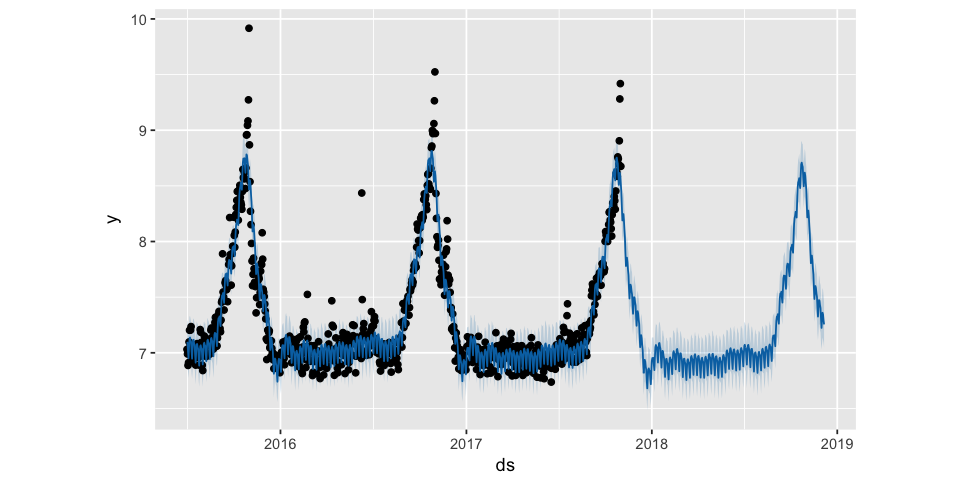

In [17]:
plot(m, forecast)

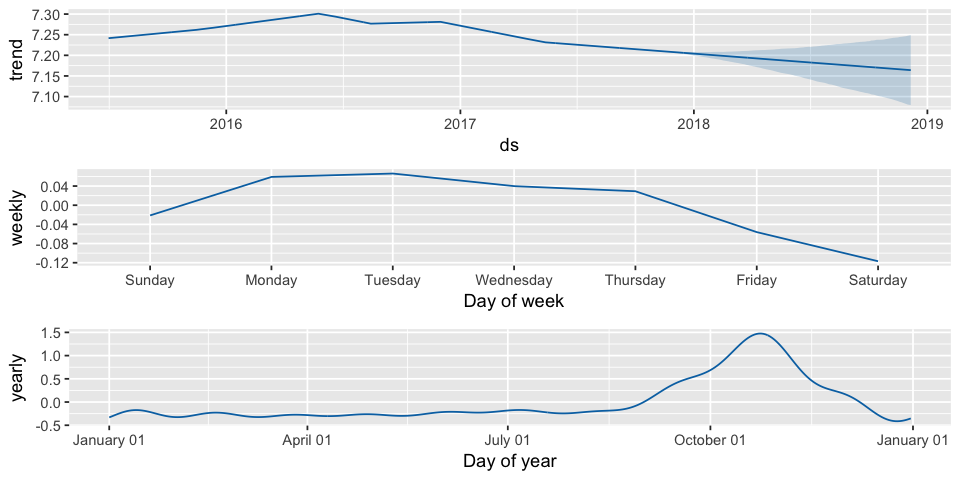

In [18]:
prophet_plot_components(m, forecast)

# How's this forecast doing?
Questions you may want to ask yourself
1. Is the seasonality correctly captured?
2. Are outliers causing any problems?
3. Is there evidence of overfitting?

# Observations:

1. Forecast seems to do a good job of ignoring outlier. (can be challenging for more ARIMA-type models)
2. Not doing a good job of picking up Thanksgiving effect.
3. Not quite responding to the extremes of Halloween.

# Let's add holidays to our model.

In [19]:
halloween <- data_frame(
    holiday = 'halloween',
    ds = as.Date(c('2015-10-31', '2016-10-31', '2017-10-31', '2018-10-31'))
)

# Now you: add thanksgiving to the holidays dataframe

Thanksgiving dates:
 * 2015-11-26
 * 2016-11-24
 * 2017-11-23
 * 2018-11-22

In [20]:
thanksgiving <- data_frame(
  holiday = 'thanksgiving',
  ds = as.Date(c('2015-11-26', '2016-11-24', '2017-11-23', '2018-11-22'))
)

holidays <- bind_rows(thanksgiving, halloween)

m <- pumpkin.views %>% 
    prophet(holidays = holidays)
forecast <- predict(m, future)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -5.53759
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


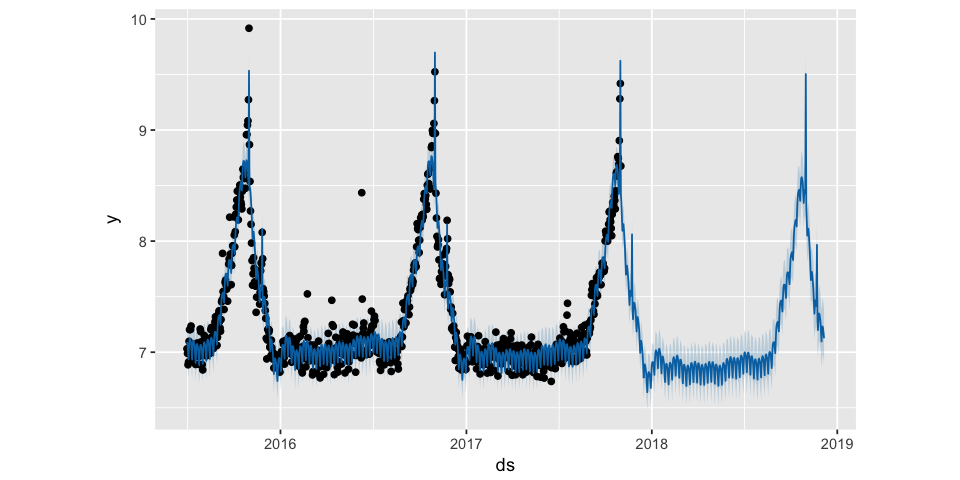

In [21]:
plot(m, forecast)

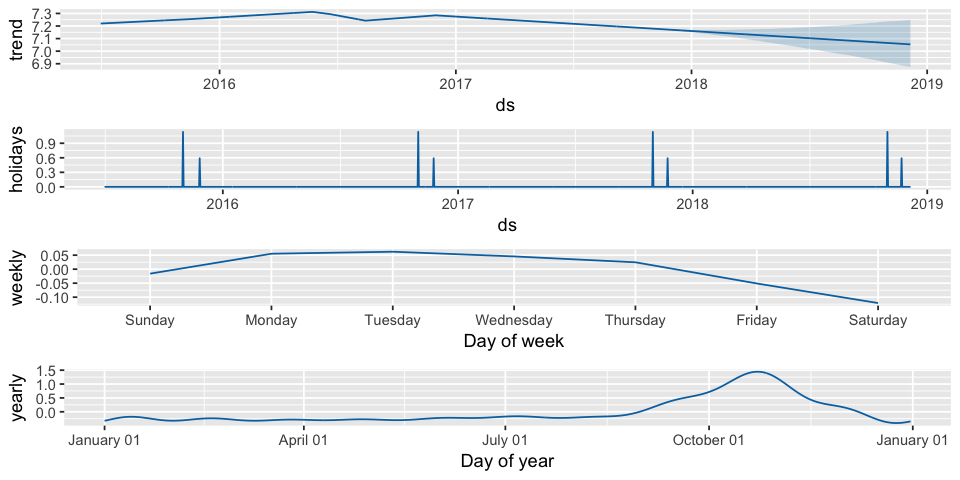

In [22]:
prophet_plot_components(m, forecast)

# Ok how's this look now?

* Seems much better able to respond to peaks around holidays 
* Still not sure I'm convinced by the predicted downward trend
* May be too many trend changepoints
* Run-up to holidays is still challenging

# Add `lower_window` column to holidays dataframe to capture holiday runup

In [23]:
halloween <- data_frame(
    holiday = 'halloween',
    ds = as.Date(c('2015-10-31', '2016-10-31', '2017-10-31', '2018-10-31')),
    lower_window = -7,
    upper_window = 0
)
thanksgiving <- data_frame(
  holiday = 'thanksgiving',
  ds = as.Date(c('2015-11-26', '2016-11-24', '2017-11-23', '2018-11-22')),
  lower_window = -7,
    upper_window = 0
)
holidays <- bind_rows(thanksgiving, halloween)

m <- pumpkin.views %>% 
    prophet(holidays = holidays)
forecast <- predict(m, future)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -5.53759
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


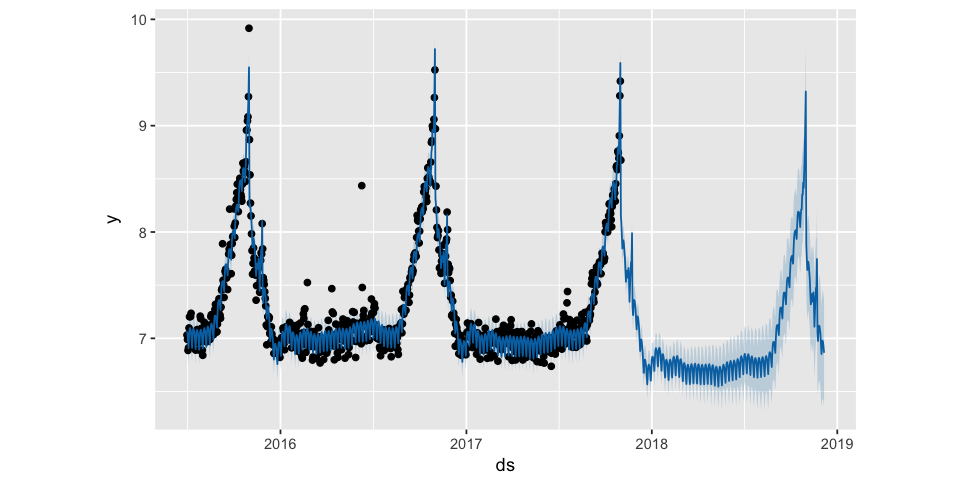

In [24]:
plot(m, forecast)

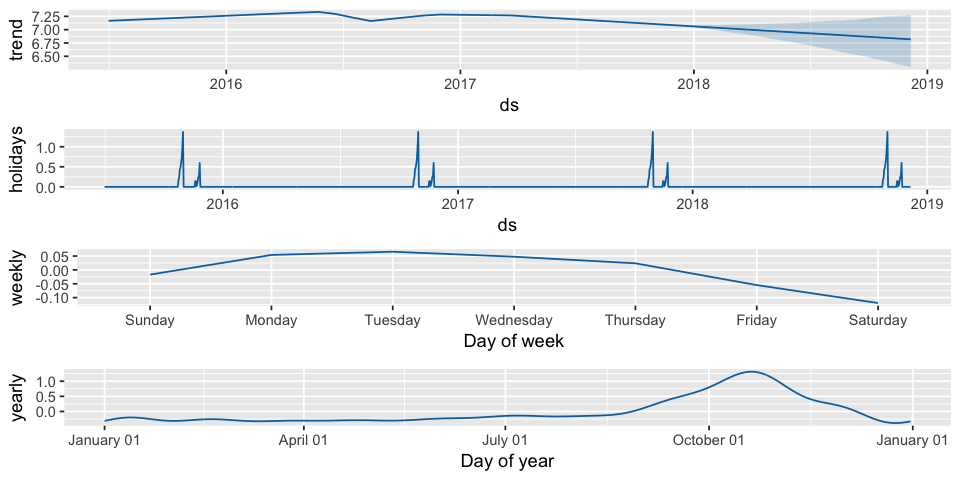

In [25]:
prophet_plot_components(m, forecast)

# Critique

* Trend seems like it's doing too much

# Adjust the `changepoint.prior.scale` parameter to decrease the number of changepoints

In [26]:
m <- pumpkin.views %>% 
    prophet(holidays = holidays,
           changepoint.prior.scale = .01)
forecast <- predict(m, future)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -5.53759
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


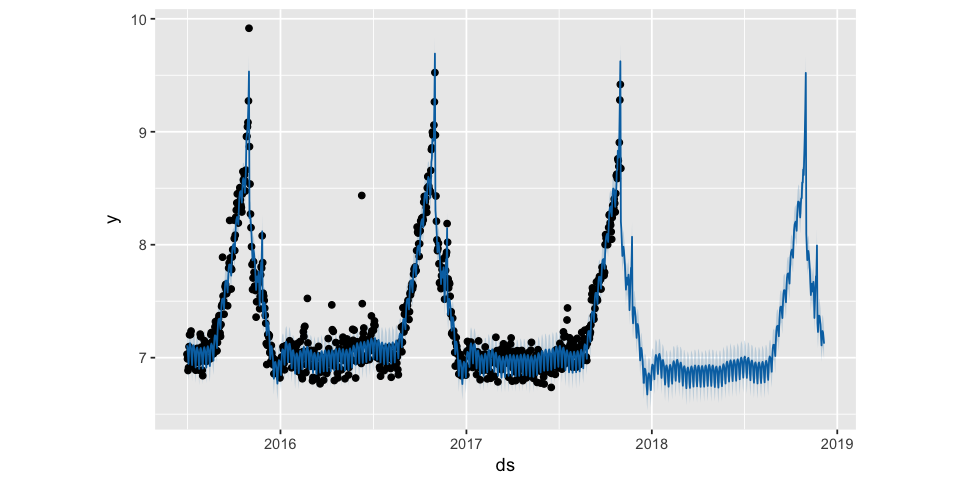

In [27]:
plot(m, forecast)

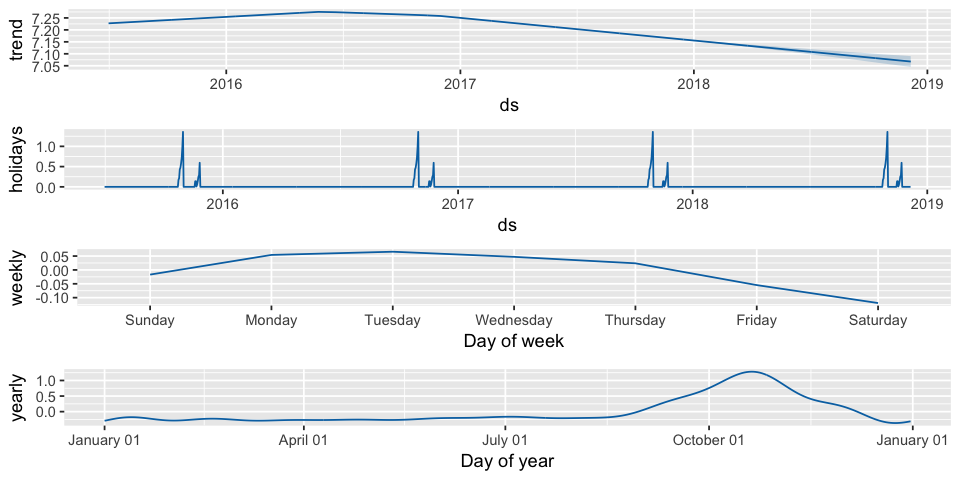

In [28]:
prophet_plot_components(m, forecast)

# Now what?

* Forecast uncertainty has decreased a lot (priors matter)
* Trend has been smoothed
* Maybe outlier matters?

# Remove the outlier!
* use `filter`

In [29]:
m <- pumpkin.views %>% 
    filter(as.Date(ds) != as.Date('2016-06-09')) %>%
    prophet(weekly.seasonality = TRUE, yearly.seasonality = TRUE,
            holidays = holidays, seasonality.prior.scale = 1,
           changepoint.prior.scale = .01)
forecast <- predict(m, future)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Initial log joint probability = -5.53479
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


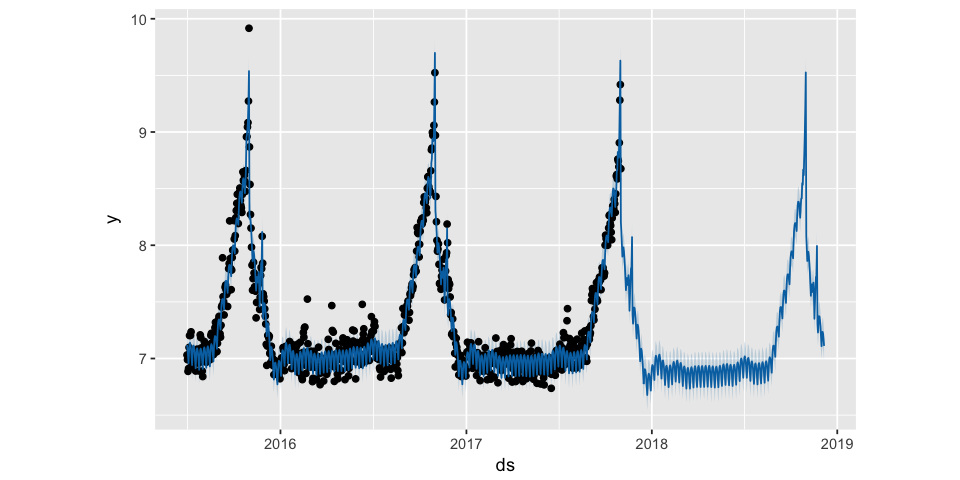

In [30]:
plot(m, forecast)

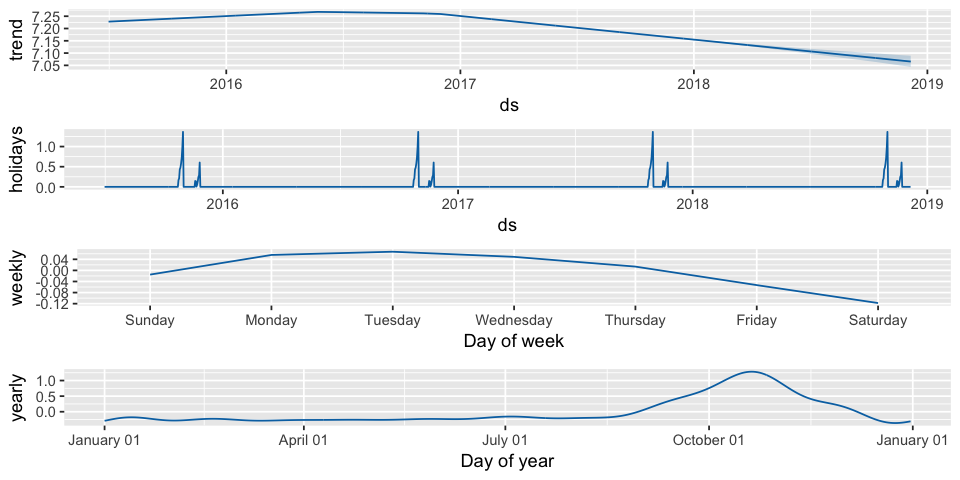

In [31]:
prophet_plot_components(m, forecast)

# Now what?

* Removing the outlier didn't do much, but didn't hurt either!


# [Now, Profit](https://www.youtube.com/watch?v=3w5D9yJUMOc&start=15)

# Try building a forecast of another series!

Recommendation: try something with strong trend changes

Thanks!

## Isaac Laughlin 
* linkedin.com/in/ilaughlin
* isaac.laughlin@gmail.com